In [34]:
# Importing required libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import numpy as np
from celluloid import Camera
from scipy.interpolate import make_interp_spline
import ffmpeg

In [35]:
# Max time in seconds
MAX_TIME = 15
# Move count (frame count)
MOVE_COUNT = 150

In [36]:
def read_input_ouput_times_from_file(file_name):
    times_file = open(file_name, "r")
    list_of_customers_times = times_file.read().split("\n")
    list_of_customers_times.pop()
    customer_count = len(list_of_customers_times)
    customers_times = np.zeros((customer_count, 2), dtype = np.float64)

    cur_customer = 0
    for cur_times in list_of_customers_times:
        input_time, output_time = cur_times.split(" ")
        customers_times[cur_customer][0] = float(input_time)
        customers_times[cur_customer][1] = float(output_time)
        cur_customer += 1
    times_file.close()
    
    return customers_times

In [37]:
# Calculate PI 1 customer's moving in time
def calculate_moving_for_pi_1(time_in, time_out):
    x = np.linspace(-10, 19, 30)

    time_for_move = 1
    time_for_move_before_intersection = 1
    time_for_move_after_intersection = 1
    x_moving = np.full(MOVE_COUNT, -10, dtype = np.float64)
    one_move_size = MAX_TIME / MOVE_COUNT
    
    i = 0
    start_pos = 0
    for cur_move in range(MOVE_COUNT):
        cur_time = one_move_size * cur_move
        if cur_time < time_in - time_for_move_before_intersection:
            continue
        elif cur_time < time_in:
            x_moving[cur_move] = x[i]
            i += 1
        elif cur_time < time_out - time_for_move:
            x_moving[cur_move] = start_pos
        elif cur_time < time_out + time_for_move_after_intersection:
            x_moving[cur_move] = x[i]
            i += 1
        else:
            break
    return x_moving

In [38]:
# Calculate PI 2 trajectory
def pi_2_trajectory(vert_point_count = 1000, circle_point_count = 1000, hor_point_count = 1000):
    center_x = 6
    center_y = 5
    radius = 1

    x_vert = np.full(vert_point_count, 5, dtype = np.float64)
    y_vert = np.linspace(10, 5, vert_point_count, dtype = np.float64, endpoint = False)

    x_circle = np.linspace(5, 6, circle_point_count, dtype = np.float64, endpoint = False)
    y_circle = np.zeros(circle_point_count, dtype = np.float64)
    y_circle = np.multiply((x_circle - center_x), (x_circle - center_x))
    y_circle = radius - y_circle
    y_circle = np.sqrt(y_circle)
    y_circle = center_y - y_circle

    x_hor = np.linspace(6, 10, hor_point_count, dtype = np.float64)
    y_hor = np.full(hor_point_count, 4, dtype = np.float64)
    x = np.concatenate((x_vert, x_circle, x_hor), axis = 0)
    y = np.concatenate((y_vert, y_circle, y_hor), axis = 0)
    
    return x, y

In [39]:
# Calculate PI 2 customer's moving in time
def calculate_moving_for_pi_2(time_in, time_out):
    count_for_sec = MOVE_COUNT / MAX_TIME
    vert_point_count = int(count_for_sec // 3)
    circle_point_count = int(count_for_sec // 3 + count_for_sec % 3)
    hor_point_count = int(count_for_sec // 3)
    x_on_intersecection, y_on_intersecection = pi_2_trajectory(vert_point_count, circle_point_count, hor_point_count)

    x_before_intersection = np.full(10, 5)
    y_before_intersection = np.linspace(20, 10, 10, endpoint=False)

    x_after_intersection = np.linspace(11, 20, 10)
    y_after_intersection = np.full(10, 4)
    all_x = np.concatenate((x_before_intersection, x_on_intersecection, x_after_intersection), axis = 0)
    all_y = np.concatenate((y_before_intersection, y_on_intersecection, y_after_intersection), axis = 0)

    time_for_move = 1
    time_for_move_before_intersection = 1
    time_for_move_after_intersection = 1
    x_moving = np.full(MOVE_COUNT, -10, dtype = np.float64)
    y_moving = np.full(MOVE_COUNT, -10, dtype = np.float64)
    one_move_size = MAX_TIME / MOVE_COUNT
    
    i = 0
    start_pos_x = 5
    start_pos_y = 10
    for cur_move in range(MOVE_COUNT):
        cur_time = one_move_size * cur_move
        if cur_time < time_in - time_for_move_before_intersection:
            continue
        elif cur_time < time_in:
            x_moving[cur_move] = all_x[i]
            y_moving[cur_move] = all_y[i]
            i += 1
        elif cur_time < time_out - time_for_move:
            x_moving[cur_move] = start_pos_x
            y_moving[cur_move] = start_pos_y
        elif cur_time < time_out + time_for_move_after_intersection:
            x_moving[cur_move] = all_x[i]
            y_moving[cur_move] = all_y[i]
            i += 1
        else:
            break
    return x_moving, y_moving

In [40]:
# Calculate PI 3 customer's moving in time
def calculate_moving_for_pi_3(time_in, time_out):
    y = np.linspace(2, 6, 100)

    time_for_move = 10
    y_moving = np.full(MOVE_COUNT, -10, dtype = np.float64)
    one_move_size = MAX_TIME / MOVE_COUNT
    
    i = 0
    start_pos = 2
    for cur_move in range(MOVE_COUNT):
        cur_time = one_move_size * cur_move
        if cur_time < time_in:
            continue
        elif cur_time < time_out - time_for_move:
            y_moving[cur_move] = start_pos
        elif cur_time < time_out:
            y_moving[cur_move] = y[i]
            i += 1
        else:
            break
    return y_moving

In [41]:
# Calculate customer's moving in time
def calculate_queue_in_time(customers_times):
    queue_length_in_time = np.zeros(MOVE_COUNT, dtype = np.int64)
    scale = MOVE_COUNT / MAX_TIME
    for input_time, output_time in customers_times:
        input_move = int(input_time * scale)
        output_move = int(output_time * scale)
        queue_length_in_time[input_move:output_move] = np.add(queue_length_in_time[input_move:output_move], 1)

    return queue_length_in_time

In [42]:
# Read data
pi_1_customers_times = read_input_ouput_times_from_file(file_name = "pi_1_times_io.txt")
pi_2_customers_times = read_input_ouput_times_from_file(file_name = "pi_2_times_io.txt")
pi_3_customers_times = read_input_ouput_times_from_file(file_name = "pi_3_times_io.txt")

# Calculate moving for all customers
all_pi_1_customers_moving = []
for input_time, output_time in pi_1_customers_times:
    all_pi_1_customers_moving.append(calculate_moving_for_pi_1(input_time, output_time))

all_pi_2_customers_x_moving = []
all_pi_2_customers_y_moving = []
for input_time, output_time in pi_2_customers_times:
    x, y = calculate_moving_for_pi_2(input_time, output_time)
    all_pi_2_customers_x_moving.append(x)
    all_pi_2_customers_y_moving.append(y)

all_pi_3_customers_moving = []
for input_time, output_time in pi_3_customers_times:
    all_pi_3_customers_moving.append(calculate_moving_for_pi_3(input_time, output_time))

# Calculate queue length
pi_1_queue_length_in_time = calculate_queue_in_time(pi_1_customers_times)
pi_2_queue_length_in_time = calculate_queue_in_time(pi_2_customers_times)
pi_3_queue_length_in_time = calculate_queue_in_time(pi_3_customers_times)

In [43]:
def read_greem_light_time_from_file(file_name):
    times_file = open(file_name, "r")
    list_of_greenlight_times = times_file.read().split("\n")
    list_of_greenlight_times.pop()
    str_count = len(list_of_greenlight_times)
    greenlights_times = np.zeros((str_count, 2), dtype = np.float64)

    cur_str = 0
    for cur_times in list_of_greenlight_times:
        start_time, end_time = cur_times.split(" ")
        greenlights_times[cur_str][0] = float(start_time)
        greenlights_times[cur_str][1] = float(end_time)
        cur_str += 1
    times_file.close()
    
    return greenlights_times

In [44]:
# Read green light time data
pi_1_greem_light_time = read_greem_light_time_from_file(file_name = "pi_1_times_greenlight.txt")
pi_2_greem_light_time = read_greem_light_time_from_file(file_name = "pi_2_times_greenlight.txt")
pi_3_greem_light_time = read_greem_light_time_from_file(file_name = "pi_3_times_greenlight.txt")

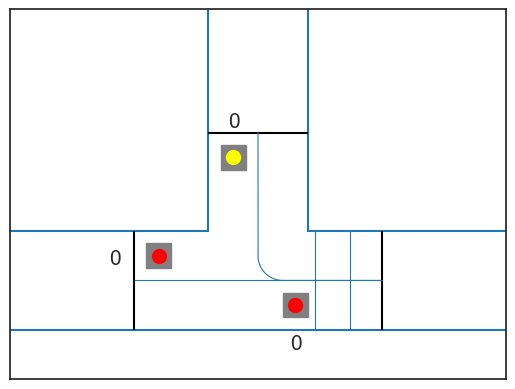

In [45]:
#%%timeit
fig, ax = plt.subplots()
ax.set_xlim([-5, 15])
ax.set_ylim([0, 15])
plt.style.use('seaborn-v0_8-white')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
# Add intersection diagram
plt.hlines(2, -5, 15)
plt.hlines(6, -5, 3.01)
plt.hlines(6, 6.99, 15)
plt.vlines(3, 6, 15)
plt.vlines(7, 6, 15)

plt.hlines(10, 3, 7, color = 'black')
plt.vlines(0, 2, 6, color = 'black')
plt.vlines(10, 2, 6, color = 'black')
# Add a plot of PI_1 moving trajectory
plt.hlines(4.01, 0, 10, lw = 0.8)
# Add a plot of PI_2 moving trajectory
x, y = pi_2_trajectory()
plt.plot(x, y, lw = 0.8)
# Add a plot of PI_3 moving trajectory
plt.vlines(7.3, 2, 6, lw = 0.8)
plt.vlines(8.7, 2, 6, lw = 0.8)
# Add a plot of 3 semathores
ax.add_patch(
     patches.Rectangle(
        (0.5, 4.5),
        1,
        1,
        edgecolor = 'gray',
        facecolor = 'gray',
        fill=True
     ) )
ax.add_patch(
    patches.Rectangle(
        (3.5, 8.5),
        1,
        1,
        edgecolor = 'gray',
        facecolor = 'gray',
        fill=True
    ) )
ax.add_patch(
    patches.Rectangle(
        (6, 2.5),
        1,
        1,
        edgecolor = 'gray',
        facecolor = 'gray',
        fill=True
    ) )

scat_pi_1 = ax.scatter(0, 0, color = 'red' , s = 200)
scat_pi_2 = ax.scatter(0, 0, color = 'red' , s = 200)
scat_pi_3 = ax.scatter(0, 0, color = 'red' , s = 10)
time_template = '%d'
tex_pi_1 = ax.text(0.2, 0.31, '', transform=ax.transAxes, fontsize=15)
tex_pi_2 = ax.text(0.44, 0.68, '', transform=ax.transAxes, fontsize=15)
tex_pi_3 = ax.text(0.565, 0.08, '', transform=ax.transAxes, fontsize=15)
scat_greenlight_pi_1 = ax.scatter(1, 5, color = 'red' , s = 100)
scat_greenlight_pi_2 = ax.scatter(4, 9, color = 'red' , s = 100)
scat_greenlight_pi_3 = ax.scatter(6.5, 3, color = 'red' , s = 100)
greenlight_pi_1_str_id = 0
greenlight_pi_2_str_id = 0
greenlight_pi_3_str_id = 0
greenlight_pi_1_str_max_id = len(pi_1_greem_light_time)
greenlight_pi_2_str_max_id = len(pi_2_greem_light_time)
greenlight_pi_3_str_max_id = len(pi_3_greem_light_time)

one_move_size = MAX_TIME / MOVE_COUNT
def animate(i):
    global greenlight_pi_1_str_id
    global greenlight_pi_2_str_id
    global greenlight_pi_3_str_id

    pi_1_points = np.array([ [all_pi_1_customers_moving[j][i], 4] for j in range(len(all_pi_1_customers_moving)) ] )
    pi_2_points = np.array([ [all_pi_2_customers_x_moving[j][i], all_pi_2_customers_y_moving[j][i]] for j in range(len(all_pi_2_customers_x_moving)) ] )
    pi_3_points = np.array([ [7.5 + (j % 5) / 4, all_pi_3_customers_moving[j][i]] for j in range(len(all_pi_3_customers_moving)) ] )

    scat_pi_1.set_offsets(pi_1_points)
    scat_pi_2.set_offsets(pi_2_points)
    scat_pi_3.set_offsets(pi_3_points)
    
    tex_pi_1.set_text(time_template % (pi_1_queue_length_in_time[i]))
    tex_pi_2.set_text(time_template % (pi_2_queue_length_in_time[i]))
    tex_pi_3.set_text(time_template % (pi_3_queue_length_in_time[i]))

    cur_time = i * one_move_size
    if (greenlight_pi_1_str_id < greenlight_pi_1_str_max_id):
        if (cur_time < pi_1_greem_light_time[greenlight_pi_1_str_id][0] - 3.0):
            pass
        elif (cur_time < pi_1_greem_light_time[greenlight_pi_1_str_id][0]):
            scat_greenlight_pi_1.set_color( "yellow" )
        elif (cur_time < pi_1_greem_light_time[greenlight_pi_1_str_id][1]):
            scat_greenlight_pi_1.set_color( "green" )
        elif (cur_time < pi_1_greem_light_time[greenlight_pi_1_str_id][1] + 3):
            scat_greenlight_pi_1.set_color( "yellow" )
        else:
            scat_greenlight_pi_1.set_color( "red" )
            greenlight_pi_1_str_id += 1

    if (greenlight_pi_2_str_id < greenlight_pi_2_str_max_id):
        if (cur_time < pi_2_greem_light_time[greenlight_pi_2_str_id][0] - 3.0):
            pass
        elif (cur_time < pi_2_greem_light_time[greenlight_pi_2_str_id][0]):
            scat_greenlight_pi_2.set_color( "yellow" )
        elif (cur_time < pi_2_greem_light_time[greenlight_pi_2_str_id][1]):
            scat_greenlight_pi_2.set_color( "green" )
        elif (cur_time < pi_2_greem_light_time[greenlight_pi_2_str_id][1] + 3):
            scat_greenlight_pi_2.set_color( "yellow" )
        else:
            scat_greenlight_pi_2.set_color( "red" )
            greenlight_pi_2_str_id += 1

    if (greenlight_pi_3_str_id < greenlight_pi_3_str_max_id):
        if (cur_time < pi_3_greem_light_time[greenlight_pi_3_str_id][0] - 3.0):
            pass
        elif (cur_time < pi_3_greem_light_time[greenlight_pi_3_str_id][0]):
            scat_greenlight_pi_3.set_color( "yellow" )
        elif (cur_time < pi_3_greem_light_time[greenlight_pi_3_str_id][1]):
            scat_greenlight_pi_3.set_color( "green" )
        elif (cur_time < pi_3_greem_light_time[greenlight_pi_3_str_id][1] + 3):
            scat_greenlight_pi_3.set_color( "yellow" )
        else:
            scat_greenlight_pi_3.set_color( "red" )
            greenlight_pi_3_str_id += 1

    return scat_pi_1, scat_pi_2, scat_pi_3, tex_pi_1, tex_pi_2, tex_pi_3, scat_greenlight_pi_1, scat_greenlight_pi_2, scat_greenlight_pi_3

ani = FuncAnimation(fig, animate, repeat = True, frames = MOVE_COUNT, interval = 100)
ani.save('mymovie.gif', writer='pillow')
greenlight_pi_1_str_id = 0
greenlight_pi_2_str_id = 0
greenlight_pi_3_str_id = 0
ani.save("mymovie.mp4")